# Study case of the Sunspot number

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import os
import seaborn as sns
import numpy as np
import pylab
import tensorflow as tf

In [2]:
df = pd.read_csv('Sunspots.csv')
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [3]:
df.dtypes

Unnamed: 0                             int64
Date                                  object
Monthly Mean Total Sunspot Number    float64
dtype: object

In [4]:
series = np.array(df['Monthly Mean Total Sunspot Number'])

In [5]:
time = np.array(df['Unnamed: 0'])

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text major ticklabel objects>)

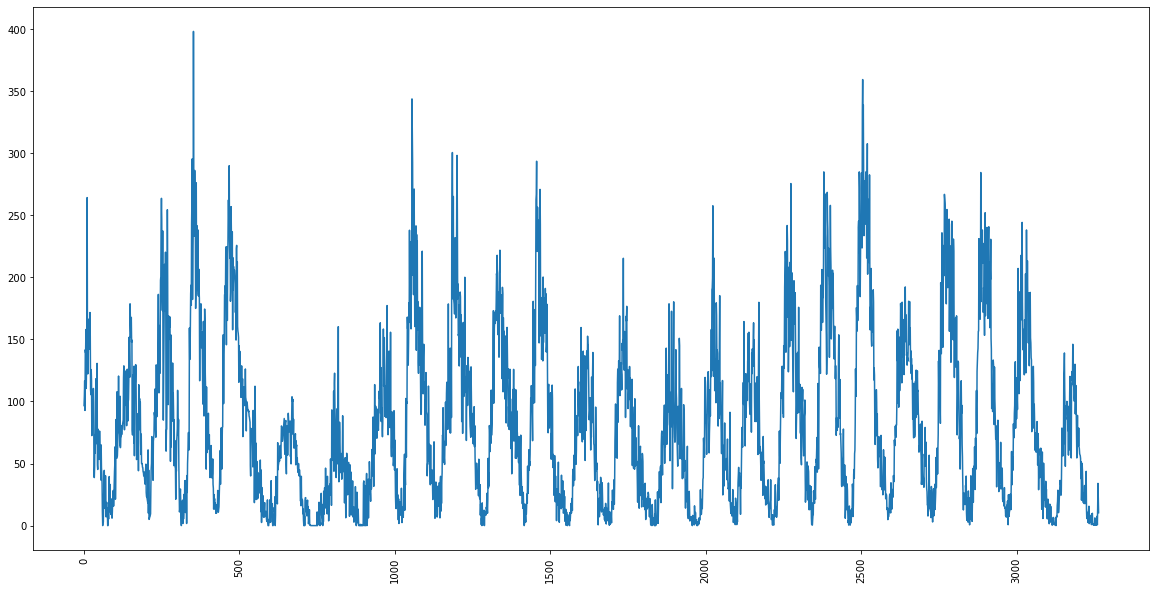

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(df['Unnamed: 0'],df['Monthly Mean Total Sunspot Number'])
plt.xticks(rotation=90)

#### Note that we have seaonality, but is not very regular with some peaks are much higher than others . We also have a bit of noise but there is not general trend.

In [7]:
# Let's split our series into a training and validation datatests

split_time= 3000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [23]:
X_train.shape

(3000,)

In [8]:
# We set all the constants 
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
# Function to turn the series into a dataset which we can train on
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) ### we use this to expand the dimensions of the series before we process it 
    ds = tf.data.Dataset.from_tensor_slices(series)               # create a dataset from the series and pass the series to it 
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # this create our window that we will apply to train 
                                                                  # out model in repetitive way and drop_remainder 
                                                                  # avoids to have an array with less that is half full
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))          # flat the data to make easy to work with  
    ds = ds.shuffle(shuffle_buffer)                               # to shuffle the data, shuffle_buffer_size is ussually
                                                                  # the amount of data that we have 
    ds = ds.map(lambda w: (w[:-1], w[1:]))                        # split the data into features and labels, for each 
                                                                  # item in the list it kind of makes sense to have all
                                                                  # the values but the last one to be the feature and 
                                                                  # then the last one be the label. 
    ds = ds.batch(batch_size).prefetch(1)                         # we batch the data, where batch_size is the numbers of
                                                                  # sets 
    return ds

In [10]:
 def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size) # get dataset which will be generate 
                                                                                    # with the fuction windowed_dataset
print(train_set)
print(X_train.shape)

model = tf.keras.models.Sequential([                       # we defince our model 
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(        # callback in orer to tweak the learning rate using a lr scheduler
    lambda epoch: 1e-8 * 10**(epoch / 20))                     # this will be called at the calleback at the end of each epoch, what will do is to change the lr to a value based on the epoch number. this will happens in each callback beacuse we set it in the callback parameter of model outfit 
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 274ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 4s 309ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 4s 353ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 4s 292ms/step - loss: 72.2678 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 4s 321ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 4s 338ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 4s 348ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 4s 337ms/step - loss: 58.1406 - mae: 58.

Epoch 71/100
12/12 [==============================] - 4s 302ms/step - loss: 20.5115 - mae: 21.0049 - lr: 3.1623e-05
Epoch 72/100
12/12 [==============================] - 3s 262ms/step - loss: 21.6034 - mae: 22.0966 - lr: 3.5481e-05
Epoch 73/100
12/12 [==============================] - 4s 335ms/step - loss: 19.4166 - mae: 19.9093 - lr: 3.9811e-05
Epoch 74/100
12/12 [==============================] - 4s 358ms/step - loss: 23.1738 - mae: 23.6674 - lr: 4.4668e-05
Epoch 75/100
12/12 [==============================] - 5s 438ms/step - loss: 21.3360 - mae: 21.8296 - lr: 5.0119e-05
Epoch 76/100
12/12 [==============================] - 4s 332ms/step - loss: 19.8000 - mae: 20.2925 - lr: 5.6234e-05
Epoch 77/100
12/12 [==============================] - 4s 353ms/step - loss: 21.4292 - mae: 21.9223 - lr: 6.3096e-05
Epoch 78/100
12/12 [==============================] - 4s 306ms/step - loss: 19.9798 - mae: 20.4725 - lr: 7.0795e-05
Epoch 79/100
12/12 [==============================] - 4s 356ms/step - lo

(1e-08, 0.0001, 0.0, 60.0)

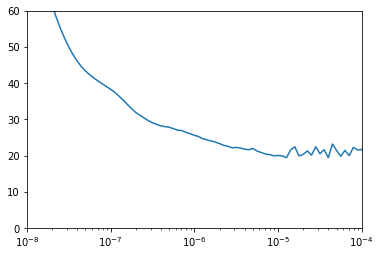

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"]) # we can then plot the last per epoch agains the lr per epoch
plt.axis([1e-8, 1e-4, 0, 60]) # we try to chosee the lowe lr

In [17]:
tf.keras.backend.clear_session()   # this clears any internal variables, that make it easy to experiment without model impacting later version of itself
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)    # this allow us to performe arbitrary operations to effectivelly expand the functionality of tf keras. Indded multiply by 400 can help training. given the default activation function  
]) 


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) # here we set the lr with the previous information 
model.compile(loss=tf.keras.losses.Huber(), # huber is more resistent to outliers
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 118ms/step - loss: 38.9182 - mae: 39.4146
Epoch 2/500
30/30 [==============================] - 3s 116ms/step - loss: 25.7631 - mae: 26.2575
Epoch 3/500
30/30 [==============================] - 3s 114ms/step - loss: 22.0827 - mae: 22.5764
Epoch 4/500
30/30 [==============================] - 4s 125ms/step - loss: 20.4713 - mae: 20.9643
Epoch 5/500
30/30 [==============================] - 4s 129ms/step - loss: 19.7339 - mae: 20.2263
Epoch 6/500
30/30 [==============================] - 4s 118ms/step - loss: 19.3347 - mae: 19.8268
Epoch 7/500
30/30 [==============================] - 4s 144ms/step - loss: 18.7302 - mae: 19.2224
Epoch 8/500
30/30 [==============================] - 4s 140ms/step - loss: 18.1358 - mae: 18.6273
Epoch 9/500
30/30 [==============================] - 4s 125ms/step - loss: 18.0753 - mae: 18.5669
Epoch 10/500
30/30 [==============================] - 4s 118ms/step - loss: 18.3835 - mae: 18.8747
Epoch 11/500
30/30 

30/30 [==============================] - 4s 120ms/step - loss: 15.9019 - mae: 16.3905
Epoch 166/500
30/30 [==============================] - 4s 127ms/step - loss: 15.8859 - mae: 16.3745
Epoch 167/500
30/30 [==============================] - 3s 114ms/step - loss: 15.9351 - mae: 16.4238
Epoch 168/500
30/30 [==============================] - 3s 112ms/step - loss: 16.0402 - mae: 16.5290
Epoch 169/500
30/30 [==============================] - 4s 143ms/step - loss: 15.8469 - mae: 16.3353
Epoch 170/500
30/30 [==============================] - 3s 113ms/step - loss: 16.0180 - mae: 16.5068
Epoch 171/500
30/30 [==============================] - 3s 116ms/step - loss: 15.8613 - mae: 16.3497
Epoch 172/500
30/30 [==============================] - 4s 122ms/step - loss: 15.9019 - mae: 16.3904
Epoch 173/500
30/30 [==============================] - 4s 119ms/step - loss: 15.8745 - mae: 16.3631
Epoch 174/500
30/30 [==============================] - 3s 116ms/step - loss: 16.0192 - mae: 16.5082
Epoch 175/500


30/30 [==============================] - 6s 186ms/step - loss: 15.5047 - mae: 15.9924
Epoch 248/500
30/30 [==============================] - 4s 120ms/step - loss: 15.6764 - mae: 16.1646
Epoch 249/500
30/30 [==============================] - 4s 118ms/step - loss: 15.6346 - mae: 16.1227
Epoch 250/500
30/30 [==============================] - 4s 142ms/step - loss: 15.4774 - mae: 15.9649
Epoch 251/500
30/30 [==============================] - 4s 135ms/step - loss: 15.5285 - mae: 16.0160
Epoch 252/500
30/30 [==============================] - 5s 166ms/step - loss: 15.5817 - mae: 16.0695
Epoch 253/500
30/30 [==============================] - 4s 121ms/step - loss: 15.4473 - mae: 15.9344
Epoch 254/500
30/30 [==============================] - 4s 130ms/step - loss: 15.4618 - mae: 15.9495
Epoch 255/500
30/30 [==============================] - 5s 164ms/step - loss: 15.4277 - mae: 15.9148
Epoch 256/500
30/30 [==============================] - 5s 160ms/step - loss: 15.4627 - mae: 15.9502
Epoch 257/500


30/30 [==============================] - 4s 127ms/step - loss: 15.1005 - mae: 15.5867
Epoch 330/500
30/30 [==============================] - 4s 125ms/step - loss: 15.2437 - mae: 15.7306
Epoch 331/500
30/30 [==============================] - 4s 126ms/step - loss: 15.1165 - mae: 15.6030
Epoch 332/500
30/30 [==============================] - 4s 124ms/step - loss: 15.1518 - mae: 15.6384
Epoch 333/500
30/30 [==============================] - 4s 126ms/step - loss: 15.1417 - mae: 15.6285
Epoch 334/500
30/30 [==============================] - 4s 124ms/step - loss: 15.0071 - mae: 15.4934
Epoch 335/500
30/30 [==============================] - 4s 127ms/step - loss: 15.0215 - mae: 15.5079
Epoch 336/500
30/30 [==============================] - 4s 126ms/step - loss: 15.0910 - mae: 15.5778
Epoch 337/500
30/30 [==============================] - 4s 128ms/step - loss: 15.1314 - mae: 15.6182
Epoch 338/500
30/30 [==============================] - 4s 128ms/step - loss: 15.2337 - mae: 15.7203
Epoch 339/500


30/30 [==============================] - 4s 124ms/step - loss: 14.7463 - mae: 15.2322
Epoch 412/500
30/30 [==============================] - 4s 127ms/step - loss: 14.8427 - mae: 15.3291
Epoch 413/500
30/30 [==============================] - 4s 124ms/step - loss: 14.7950 - mae: 15.2813
Epoch 414/500
30/30 [==============================] - 4s 125ms/step - loss: 14.7964 - mae: 15.2826
Epoch 415/500
30/30 [==============================] - 4s 129ms/step - loss: 14.8989 - mae: 15.3855
Epoch 416/500
30/30 [==============================] - 4s 125ms/step - loss: 15.2395 - mae: 15.7270
Epoch 417/500
30/30 [==============================] - 4s 127ms/step - loss: 14.7410 - mae: 15.2268
Epoch 418/500
30/30 [==============================] - 4s 126ms/step - loss: 14.7722 - mae: 15.2580
Epoch 419/500
30/30 [==============================] - 4s 125ms/step - loss: 14.7467 - mae: 15.2326
Epoch 420/500
30/30 [==============================] - 4s 127ms/step - loss: 14.8712 - mae: 15.3576
Epoch 421/500


30/30 [==============================] - 4s 126ms/step - loss: 14.5396 - mae: 15.0251
Epoch 494/500
30/30 [==============================] - 4s 126ms/step - loss: 14.4249 - mae: 14.9106
Epoch 495/500
30/30 [==============================] - 4s 125ms/step - loss: 14.6156 - mae: 15.1019
Epoch 496/500
30/30 [==============================] - 4s 130ms/step - loss: 14.4808 - mae: 14.9668
Epoch 497/500
30/30 [==============================] - 4s 126ms/step - loss: 14.5462 - mae: 15.0325
Epoch 498/500
30/30 [==============================] - 4s 124ms/step - loss: 14.4769 - mae: 14.9627
Epoch 499/500
30/30 [==============================] - 4s 128ms/step - loss: 14.6500 - mae: 15.1364
Epoch 500/500
30/30 [==============================] - 4s 127ms/step - loss: 14.3715 - mae: 14.8569


In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

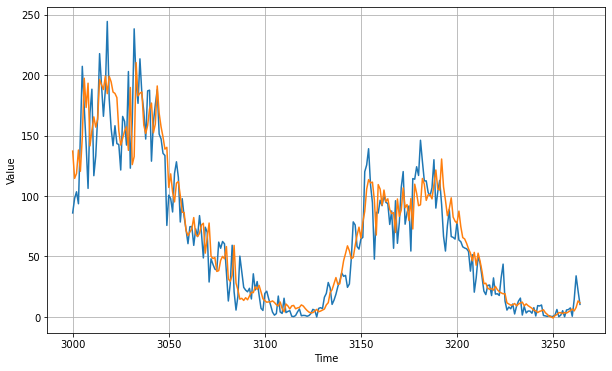

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, X_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
tf.keras.metrics.mean_absolute_error(X_valid, rnn_forecast).numpy()

14.1878

<Figure size 432x288 with 0 Axes>

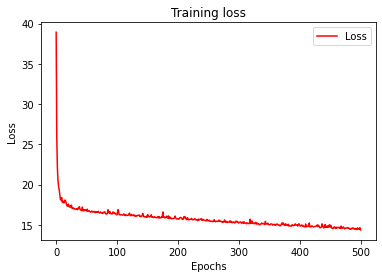

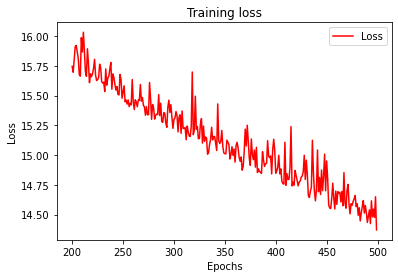

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')  # we want the minimum loss, someties increasing the range we can seee that the loss keep decreasing 
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [21]:
print(rnn_forecast)

[ 1.37120956e+02  1.14564636e+02  1.18644142e+02  1.38025360e+02
  1.20460487e+02  1.48517410e+02  1.97380737e+02  1.73180145e+02
  1.93260727e+02  1.41442108e+02  1.54231705e+02  1.65436600e+02
  1.56936081e+02  1.63519989e+02  1.96377960e+02  1.91994492e+02
  1.88041397e+02  1.99061432e+02  1.84621506e+02  1.98984558e+02
  1.94420731e+02  1.85961258e+02  1.84823425e+02  1.81358063e+02
  1.53959930e+02  1.42093903e+02  1.47706421e+02  1.53713745e+02
  1.57212219e+02  1.37758118e+02  1.89727264e+02  1.25977585e+02
  1.32635956e+02  2.10292908e+02  1.82762375e+02  1.84993378e+02
  1.85986450e+02  1.58664307e+02  1.51754272e+02  1.58283478e+02
  1.71988052e+02  1.76842880e+02  1.52242859e+02  1.59433029e+02
  1.90992920e+02  1.68336243e+02  1.57179764e+02  1.48898895e+02
  1.38756607e+02  1.40252960e+02  1.07076797e+02  1.18318367e+02
  1.03235100e+02  9.51226196e+01  1.10698532e+02  1.11973251e+02
  1.00301071e+02  8.66143723e+01  8.63246307e+01  7.14041214e+01
  6.72588348e+01  7.02059